<a href="https://colab.research.google.com/github/Anwesha-code/LaunchEd_CapstoneProject/blob/main/RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Overview:** Business Problem: To ensure there is no discrimination between employees, it is imperative for the Human Resources department of Company X to maintain a salary range for each employee with a similar profile. Apart from the existing salary, a considerable number of factors, such as an employee’s experience and other abilities, are evaluated during interviews. Given the data related to individuals who applied to Company X, models can be built that automatically determine the salary to be offered if a prospective candidate is selected. This model seeks to minimize human judgment in salary decisions.

---
Goal & Objective: The objective of this exercise is to build a model, using historical data, that will determine the salary to be offered to an employee, minimizing manual judgment in the selection process. The approach aims to be robust and eliminate any discrimination in salary among employees with similar profiles.

---




### **✅UPLOADING THE EXCEL(DATASET) FILE AS PROVIDED**

We were provided with the dataset with name 'exprcted_ctc'. To use a model, we must upload the dataset as the first step.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving expected_ctc.csv to expected_ctc.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('expected_ctc.csv')
print(df.shape)
print(df.count())

(25000, 29)
IDX                                  25000
Applicant_ID                         25000
Total_Experience                     25000
Total_Experience_in_field_applied    25000
Department                           22222
Role                                 24037
Industry                             24092
Organization                         24092
Designation                          21871
Education                            25000
Graduation_Specialization            18820
University_Grad                      18820
Passing_Year_Of_Graduation           18820
PG_Specialization                    17308
University_PG                        17308
Passing_Year_Of_PG                   17308
PHD_Specialization                   13119
University_PHD                       13119
Passing_Year_Of_PHD                  13119
Curent_Location                      25000
Preferred_location                   25000
Current_CTC                          25000
Inhand_Offer                         25000

**MAJOR OBSERVATIONS IN THE DATASET**
*   There are many categorical features in the given dataset.
*   Some features(like Organization, University_Grad) are likely to have a very high cardinality.

*   Strong predictors are- Total_Experience, Current_CTC, Certifications
*   There are a lot of NA values or missing values.

### **✅CLEANING THE DATASET**

Fixing, or removing incorrect, incomplete, or irrelevent data before training the model.

---
*   Replace null values or empty strings
*   Create derived features as required
*   Dropping any unecessary columns
*   Filling any missing values
*   Encode categorical or binary columns (there are many categorical features.)
*   One hot encode other categorical variables

In [ ]:
import numpy as np
import pandas as pd

df.replace(['NA', ''], np.nan, inplace=True)                 #Replace NA and empty strings

if 'Passing_Year_Of_Graduation' in df.columns:                  #Create derived features
    df['Years_Since_Grad'] = 2025 - df['Passing_Year_Of_Graduation'].astype(float)

if 'Passing_Year_Of_PG' in df.columns:
    df['Years_Since_PG'] = 2025 - df['Passing_Year_Of_PG'].astype(float)

columns_to_drop = [                            #Drop unecessary columns
    'IDX', 'Applicant_ID', 'Organization',
    'University_Grad', 'University_PG', 'University_PHD',
    'PHD_Specialization', 'Passing_Year_Of_PHD',
    'Passing_Year_Of_Graduation', 'Passing_Year_Of_PG',
    'Number_of_Publications']
existing_cols = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_cols, inplace=True)

    #Filling missing values
df['Total_Experience'] = df['Total_Experience'].fillna(df['Total_Experience'].median())
df['Certifications'] = df['Certifications'].fillna(0)
df['Role'] = df['Role'].fillna('Unknown')
df['Education'] = df['Education'].fillna('Grad')

df['Inhand_Offer'] = df['Inhand_Offer'].map({'Y': 1, 'N': 0})          #Encode categorical or binary columns
df['International_degree_any'] = df['International_degree_any'].astype(int)

rating_map = {'A': 3, 'B': 2, 'C': 1, 'Key_Performer': 4}
df['Last_Appraisal_Rating'] = df['Last_Appraisal_Rating'].map(rating_map)

df = pd.get_dummies(df, columns=[             #One hot encode any other categorical variables
    'Department', 'Role', 'Industry', 'Designation',
    'Education', 'Graduation_Specialization', 'PG_Specialization'], drop_first=True)


print(df.isnull().sum())

df.drop(columns=['Curent_Location', 'Preferred_location'], inplace=True)        #Drop unneeded location columns

df['Last_Appraisal_Rating'] = df['Last_Appraisal_Rating'].fillna(df['Last_Appraisal_Rating'].median())    # Fill missing values in ratings
df['Years_Since_Grad'] = df['Years_Since_Grad'].fillna(df['Years_Since_Grad'].median())
df['Years_Since_PG'] = df['Years_Since_PG'].fillna(df['Years_Since_PG'].median())
df.rename(columns={'Curent_Location': 'Current_Location'}, inplace=True)

low_freq_cols = [col for col in df.columns if df[col].dtype == 'bool' and df[col].sum() < (0.005 * len(df))]         # Drop very sparse one-hot encoded features (optional)
df.drop(columns=low_freq_cols, inplace=True)

print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.info())
print(df.isnull().sum())
print(df.head())

Total_Experience                     0
Total_Experience_in_field_applied    0
Curent_Location                      0
Preferred_location                   0
Current_CTC                          0
                                    ..
PG_Specialization_Others             0
PG_Specialization_Psychology         0
PG_Specialization_Sociology          0
PG_Specialization_Statistics         0
PG_Specialization_Zoology            0
Length: 98, dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 90 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Total_Experience                       25000 non-null  int64  
 1   Total_Experience_in_field_applied      25000 non-null  int64  
 2   Current_CTC                            25000 non-null  int64  
 3   Inhand_Offer                           25000 non-null  int64  
 4   Last_Appraisal_Rating 

### **✅TRAIN-TEST SPLIT AND TRAINING THE MODEL**

Dividing the dataset into two parts:

*   **Training set-** I used 80% of Dataset to train the model.
*   **Testing set-** I used 20% of Dataset to do the testing of the model.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

X = df.drop(columns=['Expected_CTC'])
y = df['Expected_CTC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    # Train-test split

scaler = StandardScaler()                #Scaling the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**HOW TO CHOOSE THE MODEL**
*   In the end, we are predicting a numeric value, i.e. Expected_CTC.
*   Many features like experience, education, domain, Current_CTC, etc. are to be taken in consideration.
Ultimately this is a **regression** problem, as our output (Expected CTC) is a continuous value.

---
Models that I think can be used are:

*   Linear Regression
*   Random Forest Regressor
*   Gradient Boosting Regressor

---

I will use all these three models, and will check each of their accuracy.

Here I am using **Random Forest Regressor Model**.



In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

### **✅MODEL EVALUATION**

Check how well the model performs after training. It helps measure the accuracy and errors.

**MSE**: Measures the average squared difference between actual and predicted values.

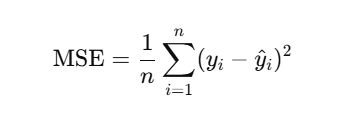


Useful for understanding how far predictions are from actual values.

**Lower MSE = better mode**l

**R² Score**:

Ranges between 0 to 1 (or negative if very poor).

Tells how good your model is compared to a baseline (mean) model.

R² = 1 means perfect prediction, R² = 0 means predictions are no better than guessing the mean.

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred = rf.predict(X_test_scaled)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)



R² Score: 0.9958806849100306
MAE: 44511.01067323416
RMSE: 74640.9805186351


### **✅TESTING THE MODEL**

I created a dictionary with a random candidate's entries to test the model.

In [ ]:
import pandas as pd

candidate_dict = {
    'Total_Experience': 6,
    'Total_Experience_in_field_applied': 5,
    'Current_CTC': 900000,
    'Inhand_Offer': 0,
    'Last_Appraisal_Rating': 3,
    'No_Of_Companies_worked': 2,
    'Certifications': 1,
    'International_degree_any': 0,
    'Years_Since_Grad': 4,
    'Years_Since_PG': 2,
    'Role_Data scientist': 1,               #set the correct one-hot fields = 1
    'Department_IT-Software': 1,
    'Education_PG': 1,
    'PG_Specialization_Engineering': 1}

candidate_df = pd.DataFrame([candidate_dict])           #creating a dataframe from the dictionary created above

candidate_df = candidate_df.reindex(columns=X.columns, fill_value=0)

candidate_scaled = scaler.transform(candidate_df)         #scaling the input

predicted_salary = rf.predict(candidate_scaled)[0]

print(f"Expected Salary (CTC): ₹{predicted_salary:,.2f}")


Expected Salary (CTC): ₹1,214,645.26


### **✅FEATURE IMPORTANCE**

Which input features or columns have the highest impact on the model's predictions.

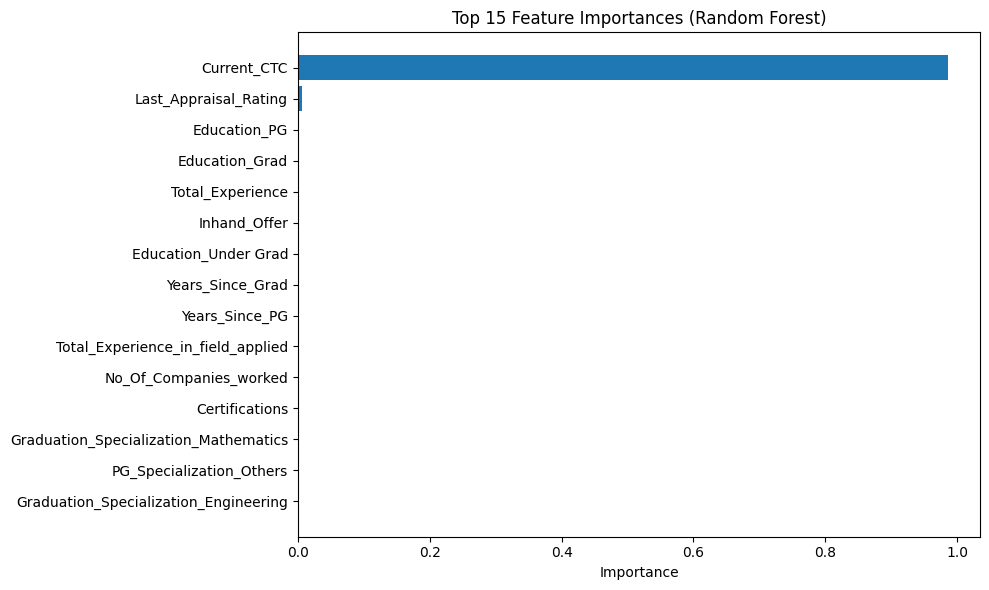

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_             #feature importances
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
